In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

2022-06-20 16:37:43.681646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


**Resources** :

*Matrix Factorization techniques for Recommender Systems*, Koren (2009)    
https://www.inf.unibz.it/~ricci/ISR/papers/ieeecomputer.pdf

Hands on Machine Learning with scikit-learn and tensorflow:             
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

The movieLens dataset:                                                
https://grouplens.org/datasets/movielens/ 

Keras Functional API doc :                                            
https://keras.io/guides/functional_api/


# Recommender systems : collaborative filtering via matrix factorization

Do you wonder how Netflix is able to recommend you movies despite it doesn't know anything about you but the ratings you gave to the movies you watched ? This is what we are going to explore during this 3 days machine learning module.

First off, let's learn about what are recommender system, collaborative filtering and matrix factorization techniques, which are all very well introduced in Koren's 2009 famous article : *Matrix Factorization techniques for Recommender Systems* : https://www.inf.unibz.it/~ricci/ISR/papers/ieeecomputer.pdf . Read the 4 first pages (up to section *adding biases* included). 

Through this notebook we are going to re-implement the model described in the pages you read, and apply it to a classic movie ratings dataset coming from the website *movieLens*. To do so, we will use a powerful deep learning python library called *Keras*, that makes it easy to train complex models based on linear algebra.

## Load the dataset

For this module, we are going to use the movieLens dataset, that contains data from the movie recommending website movielens. The data is a subset of ratings from 0 to 5 given by some users of the website to a subset of movies. You can read more about it here (we are using the latest small dataset) : https://grouplens.org/datasets/movielens/ , and in the *README* file that is in the *data/ml-latest-small/* folder.

Load the ratings data from the `ratings.csv` file into a dataframe. The userId and movieId provided in the file don't start from 0, and are not contiguous (i.e. there are missing indexes).

Re-index the user and movie ids to indexes going from 0 to `nb_users` and 0 to `nb_movies` respectively, by building two dictionnaries `user_ids_map` and `movie_ids_map` that maps the file ids to your new ids. 
And finally, split the rows of this dataframe in a random 90%/10% train/test sets.

To do so, fill the `get_train_test_sets` function below, and respect the returned objects structures that are described in the docstring.


In [2]:
from sklearn.model_selection import train_test_split

def get_train_test_sets(data_path, train_prop = 0.9):
    """
    Build train and test sets and reindex userIds and MovieIds from 0 with contiguous indexes.
    
    Input: 
        data_path : string : the path to the ratings file
        train_prop : float : The proportion of the training set 
    
    Output:
        train : pandas.DataFrame : A dataframe with columns [userId, movieId, rating, timestamp], where
            the userId and movieId value have been replaced with new ids starting at 0. 
            Contains `train_prop` random entries from the input file.
        test : pandas.DataFrame : Same as `train`, contains the 1 - `train_prop` remaining entries.
        nb_users : int : Number of unique user ids
        nb_movies : int : Number of unique movie ids
        user_ids_map : dict : A mapping of original file userId to a new index starting at 0.
            Keys are int from the original userId column, values are int of the new indexation.
        movie_ids_map : dict : Same as `user_ids_map` for the movieIds.
    """
    
    #TOFILL
    
    data = pd.read_csv(data_path)

    #Creates movies and user index mappings
    unique_movie_ids = data["movieId"].unique()
    unique_movie_ids.sort()

    movie_ids_map = dict(zip(unique_movie_ids, range(len(unique_movie_ids))))
    data["movieId"] = data["movieId"].map(movie_ids_map)

    unique_user_ids = data["userId"].unique()
    unique_user_ids.sort()
    
    user_ids_map = dict(zip(unique_user_ids, range(len(unique_user_ids))))
    data["userId"] = data["userId"].map(user_ids_map)
    
    #Split in train and test
    train, test = train_test_split(data, test_size = (1 - train_prop))

    nb_users = len(user_ids_map)
    nb_movies = len(movie_ids_map)
    
    #TOKEEP
    return train, test, nb_users, nb_movies, user_ids_map, movie_ids_map

In [3]:
ratings_s_path =  '../data/ml-latest-small/ratings.csv'
train, test, nb_users, nb_movies, user_ids_map, movie_ids_map = get_train_test_sets(ratings_s_path)
dataset = pd.concat((train,test), axis = 0)

print("There are %i movies, %i users, and %i ratings" % (nb_movies, nb_users, dataset.shape[0]))

There are 9724 movies, 610 users, and 100836 ratings


In [4]:
X_train = [train["userId"].to_numpy(), train["movieId"].to_numpy()]
y_train = train["rating"].to_numpy()

X_test = [test["userId"].to_numpy(), test["movieId"].to_numpy()]
y_test = test["rating"].to_numpy()

Let's have a quick look at the ratings distribution:

In [5]:
import missingno as msno

<AxesSubplot:>

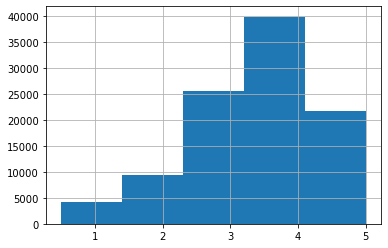

In [6]:
dataset['rating'].hist(bins=5)

In this dataset there are a lot of missing values, because not all the user/movie pairs have an associated rating. Indeed, each user rates only a few movies ! The goal of this notebook is to predict (some of) the missing user/movie ratings.

Print how many movies each of the 5 first users have rated, and print the percentage of available ratings in the whole dataset (i.e. the ratio between number of ratings and all the possible users/movies combinations):

In [7]:
#TOFILL
for user_id in range(5):
    print("User %i rated %i movies" % (user_id, (dataset.userId == user_id).sum()))
    
print("Percentage of available ratings : %0.1f %%" % (100*dataset.shape[0] / (nb_users * nb_movies) ) )

User 0 rated 232 movies
User 1 rated 29 movies
User 2 rated 39 movies
User 3 rated 216 movies
User 4 rated 44 movies
Percentage of available ratings : 1.7 %


There is only 1.7% of ratings that are available, which is normal as each hasn't rated all the movies. To see the dataset in a matrix form with all the missing ratings, use the `Dataframe.pivot()` function, with the `userId` as index, the `movieId` as columns, and the ratings for the `values` :

In [8]:
#TOFILL
data_matrix = dataset.pivot(index = "userId", columns = "movieId", values = "rating")
data_matrix

movieId  0     1     2     3     4     5     6     7     8     9     ...  \
userId                                                               ...   
0         4.0   NaN   4.0   NaN   NaN   4.0   NaN   NaN   NaN   NaN  ...   
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
605       2.5   NaN   NaN   NaN   NaN   NaN   2.5   NaN   NaN   NaN  ...   
606       4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
607       2.5   2.0   2.0   NaN   NaN   NaN   NaN   NaN   NaN   4.0  ...   
608       3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0  ...   
609       5.0   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN  ...   

movieId  9714  9715  9716  9717  9718  9719  9720  9721  9722  9723  
userId                                                               
0         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
605       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
606       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
607       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
608       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
609       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[610 rows x 9724 columns]

Print all the ratings of user 1. To do so, use the *movies.csv* file and your `movie_ids_map` dictionnary to find the movie title from the new movie indexes, and print the real movie title associated to each rating of user 1 :

In [9]:
#TOFILL
movies_info = pd.read_csv('../data/ml-latest-small/movies.csv')
ml_movie_id_to_title = dict(zip(movies_info['movieId'], movies_info['title']))

inverse_movie_ids_map = {v: k for k, v in movie_ids_map.items()}

user1_ratings = dataset[dataset.userId == 1]
user1_ratings.movieId = user1_ratings.movieId.map(inverse_movie_ids_map).map(ml_movie_id_to_title)

print(user1_ratings)

     userId                                            movieId  rating  \
260       1  The Jinx: The Life and Deaths of Robert Durst ...     5.0   
245       1                  Exit Through the Gift Shop (2010)     3.0   
242       1                        Inglourious Basterds (2009)     4.5   
254       1                    Wolf of Wall Street, The (2013)     5.0   
239       1                               Departed, The (2006)     4.0   
250       1                                     Warrior (2011)     5.0   
234       1                           Good Will Hunting (1997)     4.5   
251       1                      Dark Knight Rises, The (2012)     3.5   
244       1                              Shutter Island (2010)     4.0   
259       1                          Mad Max: Fury Road (2015)     5.0   
243       1                                  Zombieland (2009)     3.0   
241       1                               Step Brothers (2008)     5.0   
253       1                           

/tmp/ipykernel_44464/3275227372.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user1_ratings.movieId = user1_ratings.movieId.map(inverse_movie_ids_map).map(ml_movie_id_to_title)


## Matrix Factorization with Keras

Keras is a python library made for easily designing complex models such as deep learning models, in this module we are going to use just a few features from it to implement our simple matrix factorization model, as it makes a good introduction to the library before the next module about deep learning where you will also be using Keras.

The following function `get_mf_model` implements the model described in equation (2) in Koren's paper (without the $+\lambda(\ldots)$ part for the moment). So it basically tries to find the $p_u \in \mathbb{R}^k$ and $q_i \in \mathbb{R}^k$ vectors that minimizes the squared loss between their dot product $p_u^Tq_i$, and the observed ratings $r_{ui}$, from random initialization of $p_u$ and $q_i$. In machine learning terms, $p_u$ and $q_i$ are called the *embeddings* of the user $u$ and of the movie $i$ respectively. Their size $k$ is an hyper-parameter of the model, which is called the *rank* of the factorization.

To do so, it uses the functional API from Keras (the other API proposed is the sequential one, but is not adapted for this model), you can read about it here : https://keras.io/guides/functional_api/ .

Keras, unlike Numpy, uses a different progamming paradigm. Numpy uses an *imperative* programming style (like python in general), meaning that when you execute `x.dot(y)`, the dot product is actually calculated. Keras however, uses a *declarative* (also called *symbolic*) programming style, meaning that when you write `Dot()([x, y])`, you tell Keras than when you will call the *fit* function of your model in the future, you will want to do a dot product between the future values that *x* and *y* will have. And this is what Keras is about, it allows you to build your own model as a sequence of operations, describing each input and output, and then later fit it and predict with it.

Let's not get in too many details, but retain that the `get_mf_model` function below is not actually executing the model, it creates it, and returns an object of the class `keras.models.Model` that has been instructed with your model operations, and this object can then be trained with the classic `fit` and `predict` functions. 

Read carefully the comments in the code of the function to understand the different steps in the model creation process:

In [10]:
from keras.models import Model
from keras.layers import Embedding, Input, Reshape
from keras.layers import Dot

def get_mf_model(nb_users, nb_movies, k):
    """
    Build a simple matrix factorization model from
    the number of user, the number of movies, and the size of the embeddings k.
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization
        
    """
    dim_embedddings = k
    
    #Inputs:
    #First we describe the input of the model, that is the training data that we will give it as X
    #In our case, the input are just the user index u and the movie index i.
    #So we declare two inputs of size one:
    u = Input(shape=(1,), dtype='int32', name = "u__user_id")
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    
    #Then let's declare our variable, the embeddings p and q.
    #First with the users, we declare that we have nb_users embeddings, each of size dim_embeddings.
    #An embedding object is indexed by calling it with the index parameter like a function,
    #so we add a `(u)` at the end to tell keras we want it to be indexed 
    #by the user ids we will pass at training time as inputs.
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    
    #Unfortunatly, when indexing an embeddings it keeps [1,k] matrix shape instead
    #of just a [k] vector, so we have to tell Keras that we just want a vector by
    #redefining its shape:
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Same thing for the movie embeddings:
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    #Then the dot product between the two indexed embeddings, 
    #we'll understand the axes = 1 part later.
    r_hat = Dot(axes = 1)([q_i, p_u])

    #We define our model by giving its input and outputs, in our case
    #the user and movie ids will be the inputs, and the output will be
    #the estimated rating r_hat, that is the dot product of the 
    #corresponding embeddings.
    model = Model(inputs=[u, i], outputs=r_hat)
    
    #Finally, we define the loss and metric to use, in our case the mean squared error,
    #along with the optimization method, we'll understand what is 'adam' later also.
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    return model



In [11]:
k = 30
mf_model = get_mf_model(nb_users, nb_movies, k)

2022-06-20 16:37:48.421162: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-20 16:37:48.422562: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-20 16:37:48.468211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: NVIDIA GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.785GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2022-06-20 16:37:48.468261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-20 16:37:48.470800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-20 16:37:48.470913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

Keras allows us to have a textual overview of the model we defined with the *summary()* function:

In [12]:
mf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i__movie_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
u__user_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
______________________________________________________________________________________________

Each of the keras objects we defined in our model is called a *layer*, and we find them in order in the first column. The *Param #* column gives the number of trainable parameters of the layer, in our case these are just the embeddings, and they should be equal to $nb\_users \times k$ and $nb\_movies \times k$. The *Connected to* column tells for each layer which layers are inputs for this layer (you can safely ignore the `[0][0]` for this module).

Finally the *Output Shape* column gives us the shape of the layer, each layer being a *tensor*. A tensor is the generalization of matrices to more than two dimensions. So a matrix is a 2D-tensor and a vector is a 1D-tensor, and each layer can be a matrix, a vector, or a higher-order tensor. The output shape we see is indeed the expected one at each layer, except there is this `None` in first dimension, why is that ?

To understand it, we have to get into how Keras is actually minimizing the mean squared loss of our model. In general, when in comes to minimizing error functions on big datasets, a generic method is to use Stocastic Gradient Descent (SGD), briefly described in page 4 of Koren's article. 

Read about gradient descent, SGD and its variant mini-batch SGD in Chapter 4 of *Hands on ML ...* (pages 111-120):
https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

This is what Keras does when it fits the model, it initializes the $q_i$ and $p_u$ embedding vectors randomly, and then perform mini-batch SGD to find the minimum mean squared error on the training set. Since mini-batching means considering multiple training samples at the same time, Keras keeps the first dimension of each layer to stack the samples of each batch, this is why `None` is written, the actual batch_size being set at training time when calling the `fit` function. This is also why we had to set `axes=1` when calling the `Dot` layer in the `get_mf_model` function, because the first dimension (axe 0) of each layer is kept for the batches. And about the `optimizer='adam'`, it is just a variation of mini-batch SGD that is faster, we'll get into more details about SGD variations in the optional parts of this notebook.

Let's finally train our matrix factorization model on our movieLens data. The `epochs` parameter controls the number of iterations of the SGD algorithm, that is the number of times it is going to pass on each training rating and update the embeddings accordingly. Let's keep it at 20 for the moment:

In [13]:
history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20


2022-06-20 16:37:49.666032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-20 16:37:49.683110: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1700000000 Hz
2022-06-20 16:37:50.367887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


178/178 [==============================] - 2s 4ms/step - loss: 13.3003 - mse: 13.3003
Epoch 2/20
178/178 [==============================] - 1s 3ms/step - loss: 12.4101 - mse: 12.4101
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 6.5925 - mse: 6.5925
Epoch 4/20
178/178 [==============================] - 1s 3ms/step - loss: 2.7996 - mse: 2.7996
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 1.8179 - mse: 1.8179
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 1.3918 - mse: 1.3918
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 1.1438 - mse: 1.1438
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 1.0013 - mse: 1.0013
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.8893 - mse: 0.8893
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.8127 - mse: 0.8127
Epoch 11/20
178/178 [==============================] - 1

And we can now try to predict the test ratings, and report our root mean squared error like in other regression problems:

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = mf_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.1021352806741964 


You should get about 1.1/1.2 RMSE, we can probably do better !

## Train the same model on your GPU and on your CPU, and compare the training time

Keras uses the `tensorflow` python library for the computation part, if you have installed your GPU drivers and the GPU version of keras, then it will run on your GPU by default. We can force tensorflow to use the cpu instead:

In [15]:
import tensorflow as tf

with tf.device('/cpu:0'):
    mf_model = get_mf_model(nb_users, nb_movies, k)
    history = mf_model.fit(X_train, y_train, epochs=20, batch_size=512)

Epoch 1/20
178/178 [==============================] - 1s 2ms/step - loss: 13.2874 - mse: 13.2874
Epoch 2/20
178/178 [==============================] - 0s 2ms/step - loss: 12.6043 - mse: 12.6043
Epoch 3/20
178/178 [==============================] - 0s 2ms/step - loss: 7.2929 - mse: 7.2929
Epoch 4/20
178/178 [==============================] - 0s 2ms/step - loss: 3.0047 - mse: 3.0047
Epoch 5/20
178/178 [==============================] - 0s 2ms/step - loss: 1.8865 - mse: 1.8865
Epoch 6/20
178/178 [==============================] - 0s 2ms/step - loss: 1.4018 - mse: 1.4018
Epoch 7/20
178/178 [==============================] - 0s 2ms/step - loss: 1.1379 - mse: 1.1379
Epoch 8/20
178/178 [==============================] - 0s 2ms/step - loss: 0.9735 - mse: 0.9735
Epoch 9/20
178/178 [==============================] - 0s 2ms/step - loss: 0.8666 - mse: 0.8666
Epoch 10/20
178/178 [==============================] - 0s 2ms/step - loss: 0.7799 - mse: 0.7799
Epoch 11/20
178/178 [========================

Our matrix farctorization model is a really simple model, with not enough operations to parallelize on the GPU, this is why the training time is quite similar for this model. However with deep networks models the training time can be up to 10x times faster on a GPU.

## Adding user and movie bias

Let's enhance our matrix factorization model and add the user and movie biases to the rating estimation function as in equation (4) of Koren's paper ; except we will for the moment forget about the global bias $\mu$ as it is not so intuitive to implement in Keras. Fill the function below to do so:

In [16]:
from keras.layers import Add

def get_mf_bias_model(nb_users, nb_movies, k):
    """
    Build a smatrix factorization model with user and movie biases
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
        
    """
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings, name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings, name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = 1)([p_u, q_i])
    
    
    #TOFILL
    
    # User and movie biases
    b_u = Embedding(nb_users, 1, name="b_u__user_bias")(u)
    b_u = Reshape((1,), name="b_u__user_bias_reshaped")(b_u)
    b_i = Embedding(nb_movies, 1, name="b_i__movie_bias")(i)
    b_i = Reshape((1,), name="b_i__movie_bias_reshaped")(b_i)
    
    # Adding it all
    r_hat = Add()([d, b_u, b_i])
    
    # Defining the model with its inputs and outputs
    model = Model(inputs=[u, i], outputs=r_hat)
    
    # Defining the loss, optimizer and metrics to use
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    
    #TOKEEP
    return model



In [17]:
mf_bias_model = get_mf_bias_model(nb_users, nb_movies, k)

In [18]:
mf_bias_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
u__user_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
i__movie_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
____________________________________________________________________________________________

In [19]:
history = mf_bias_model.fit(X_train, y_train, epochs=20, batch_size=512)


Epoch 1/20
178/178 [==============================] - 2s 4ms/step - loss: 12.9590 - mse: 12.9590
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 10.9251 - mse: 10.9251
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 5.2640 - mse: 5.2640
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 2.2711 - mse: 2.2711
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 1.5127 - mse: 1.5127
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 1.1566 - mse: 1.1566
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 0.9842 - mse: 0.9842
Epoch 8/20
178/178 [==============================] - 1s 4ms/step - loss: 0.8590 - mse: 0.8590
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.7778 - mse: 0.7778
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.7262 - mse: 0.7262
Epoch 11/20
178/178 [========================

In [20]:
y_pred = mf_bias_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.0334073127448367 


You should get a lower RMSE, about 1.0/1.1

## Adding L2 regularization

For the moment we have omitted the regularization of the embeddings and bias parameters, as described in equation (5) of Koren's paper. We are now going to add them to the model, have a look at https://keras.io/layers/embeddings/ and https://keras.io/regularizers/ to see how to do this with keras. Fill the function below to implement it:

In [21]:
from keras import regularizers

def get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_):
    """
    Build a smatrix factorization model with user and movie biases, and L2 regularization
    
    Input:
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        k : int : The size of the embeddings
        
    Output:
        model : keras.models.Model : A keras model that implements matrix factorization with biases
            and L2 regularization
        
    """
    
    
    #TOFILL
    
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings,
                  embeddings_regularizer = regularizers.l2(lambda_), name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings,
                  embeddings_regularizer = regularizers.l2(lambda_), name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = 1)([q_i, p_u])
    
    
    # User and movie biases   
    
    # User and movie biases
    b_u = Embedding(nb_users, 1,
                  embeddings_regularizer = regularizers.l2(lambda_),  name="b_u__user_bias")(u)
    b_u = Reshape((1,), name="b_u__user_bias_reshaped")(b_u)
    b_i = Embedding(nb_movies, 1,
                  embeddings_regularizer = regularizers.l2(lambda_),  name="b_i__movie_bias")(i)
    b_i = Reshape((1,), name="b_i__movie_bias_reshaped")(b_i)

    
    # Adding it all
    r_hat = Add()([d, b_u, b_i])
    
    # Defining the model with its inputs and outputs
    model = Model(inputs=[u, i], outputs=r_hat)
    
    # Defining the loss, optimizer and metrics to use
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])

    
    
    #TOKEEP
    return model



In [22]:
lambda_ = 0.00001
mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

In [23]:
mf_bias_reg_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i__movie_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
u__user_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 30)        291720      i__movie_id[0][0]                
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 30)        18300       u__user_id[0][0]                 
____________________________________________________________________________________________

In [24]:
history = mf_bias_reg_model.fit(X_train, y_train, epochs=20, batch_size=512)


Epoch 1/20
178/178 [==============================] - 1s 3ms/step - loss: 12.9846 - mse: 12.9827
Epoch 2/20
178/178 [==============================] - 1s 4ms/step - loss: 10.9348 - mse: 10.9308
Epoch 3/20
178/178 [==============================] - 1s 4ms/step - loss: 5.3489 - mse: 5.3243
Epoch 4/20
178/178 [==============================] - 1s 4ms/step - loss: 2.3430 - mse: 2.2918
Epoch 5/20
178/178 [==============================] - 1s 4ms/step - loss: 1.5830 - mse: 1.5148
Epoch 6/20
178/178 [==============================] - 1s 4ms/step - loss: 1.2738 - mse: 1.1934
Epoch 7/20
178/178 [==============================] - 1s 4ms/step - loss: 1.0885 - mse: 0.9985
Epoch 8/20
178/178 [==============================] - 1s 3ms/step - loss: 0.9776 - mse: 0.8797
Epoch 9/20
178/178 [==============================] - 1s 4ms/step - loss: 0.9119 - mse: 0.8075
Epoch 10/20
178/178 [==============================] - 1s 4ms/step - loss: 0.8558 - mse: 0.7461
Epoch 11/20
178/178 [========================

In [25]:
y_pred = mf_bias_reg_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

 Test RMSE : 1.0383268723747023 


You should get a slightly better RMSE, but sometimes regularization is very important for achieving good test performances, in depends on the data.

## Early Stopping

Instead of setting manually the maximum number of epochs, we prefer to use *early stopping*. When training with early stopping, keras keeps a given validation set though the parameter `validation_split`, on which it is going to monitor a performance measure you give it (here the `mse`) at every epoch, and continue optimization while the mse on the validation set keeps going down, and stops it when it goes back up. This mechanism is an easy way to avoid over-fitting, you can read more about it there : https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In general when using early stopping we setup a high number of maximum epochs, that is never reach because the optimization is stopped by early stopping first :

In [26]:
from keras.callbacks import EarlyStopping

mf_bias_reg_model = get_mf_bias_l2_reg_model(nb_users, nb_movies, k, lambda_)

early_stopping = EarlyStopping(monitor='val_mse', patience=5, verbose=1, restore_best_weights=True)

history = mf_bias_reg_model.fit(X_train, y_train, epochs=50, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
160/160 [==============================] - 2s 6ms/step - loss: 13.0521 - mse: 13.0503 - val_loss: 12.1817 - val_mse: 12.1800
Epoch 2/50
160/160 [==============================] - 1s 4ms/step - loss: 11.4410 - mse: 11.4381 - val_loss: 8.5530 - val_mse: 8.5419
Epoch 3/50
160/160 [==============================] - 1s 4ms/step - loss: 6.8932 - mse: 6.8760 - val_loss: 3.6590 - val_mse: 3.6218
Epoch 4/50
160/160 [==============================] - 1s 4ms/step - loss: 2.8752 - mse: 2.8321 - val_loss: 2.2751 - val_mse: 2.2173
Epoch 5/50
160/160 [==============================] - 1s 4ms/step - loss: 1.8175 - mse: 1.7560 - val_loss: 1.7974 - val_mse: 1.7260
Epoch 6/50
160/160 [==============================] - 1s 4ms/step - loss: 1.4020 - mse: 1.3278 - val_loss: 1.5623 - val_mse: 1.4804
Epoch 7/50
160/160 [==============================] - 1s 4ms/step - loss: 1.1812 - mse: 1.0971 - val_loss: 1.4281 - val_mse: 1.3377
Epoch 8/50
160/160 [==============================] - 1s 4ms/step - lo

As you can see the training stops before 500 epochs, when the validation MSE stops decreasing during 5 consecutive epochs (the patience value = 5). 

## Grid search embedding size and regularization factor with early stopping

So for the moment we didn't grid search our model hyper-parameters, such as `k` and `lambda_`. There exists some scikit-learn wrappers for keras models in order to use scikit grid search functions, unfortunately they only work with single input keras models, which is not our case as we have two inputs: the user and the movie indexes.

So let's implement your own grid search function for the two parameters `k` and `lambda_`. With big enough datasets, it is not necessary to do a cross-validation for each hyper-parameter combination, and we can simply split the training set into a sub-training set and a validation set to test our hyper-parameters. It does work because the validation set is big enough to see enough data variations, and with very big datasets, it is anyway not possible anymore to do a full cross-validation as it takes too much time to train. 

Fill in the `grid_search` function below and use early stopping with a validation split (just like above), and retrieve the validation RMSE (you can get the MSE from the `history` variable that is returned by the `fit` method (and then take the `sqrt` of that)) for all the hyper-parameter combinations from the `param_grid` dictionary of hyper-parameter values. Call the `get_model_function` parameter (yes, you can pass functions as parameters!) to generate each model, and return the hyper-parameters that give the lowest RMSE on the 10% validation set, the RMSE value, and the best corresponding trained model.

In [27]:
import itertools


def grid_search(data, param_grid, get_model_function, nb_users, nb_movies, validation_size = 0.1):
    """
    Performs a grid search over the 
    
    Input:
        data : DataFrame : The training set to be split between training and validation sets
        param_grid : dict : Dictionary containing the values of the hyper-parameters to grid-search
        get_model_function : function : A function that returns the keras model to grid-search
        nb_users : int : The number of unique users
        nb_movies : int : The number of unique movies
        validation_size : float : Proportion of the validation set
        
    Output:
        best_params : dict : A dictionary of the best hyper-parameters values
        best_score : float : The validation RMSE corresponding to the best
        best_model : keras.Model : The model trained with the best hyper-parameters
        
    """
    
    best_score = np.inf
    best_params = {}
    best_model = None
    
    #TOFILL
    
    #Iterating over all possible hyperparameters combinations
    for params in itertools.product(*param_grid.values()):
        param_dict = { list(param_grid.keys())[i] : v for i,v in enumerate(params) }
        
        #Build model with current hyperparameter combination
        mf_model = get_model_function(nb_users, nb_movies, **param_dict)
        
        
        early_stopping = EarlyStopping(monitor='val_mse', patience=5, verbose=1, restore_best_weights=True)
        history = mf_model.fit([data["userId"].to_numpy(),data["movieId"].to_numpy()], 
                               data["rating"], epochs=50, batch_size=512, 
                               validation_split=validation_size, callbacks=[early_stopping])

        valid_rmse = sqrt(history.history['val_mse'][-1])

        print(" Validation RMSE : " + str(param_dict) +" : %s " % valid_rmse)      

        #Keep the params and score if it's the best
        if valid_rmse < best_score:
            best_score = valid_rmse
            best_params = param_dict
            best_model = mf_model
            
    #TOKEEP
    return best_params, best_score, best_model

In [28]:
lambdas_ = [0.0002, 0.00005, 0.00002]
ks = [15, 30]

param_grid = dict(k=ks, lambda_=lambdas_)

best_params, best_score, best_model = grid_search(train, param_grid, get_mf_bias_l2_reg_model,
                                      nb_users, nb_movies, validation_size = 0.1)


Epoch 1/50
160/160 [==============================] - 2s 6ms/step - loss: 12.9860 - mse: 12.9736 - val_loss: 12.2210 - val_mse: 12.2121
Epoch 2/50
160/160 [==============================] - 1s 4ms/step - loss: 11.6053 - mse: 11.5851 - val_loss: 9.6509 - val_mse: 9.5408
Epoch 3/50
160/160 [==============================] - 1s 4ms/step - loss: 8.4451 - mse: 8.2683 - val_loss: 5.7732 - val_mse: 5.3651
Epoch 4/50
160/160 [==============================] - 1s 4ms/step - loss: 4.9508 - mse: 4.4645 - val_loss: 3.9809 - val_mse: 3.2843
Epoch 5/50
160/160 [==============================] - 1s 4ms/step - loss: 3.5618 - mse: 2.8124 - val_loss: 3.4092 - val_mse: 2.5285
Epoch 6/50
160/160 [==============================] - 1s 4ms/step - loss: 3.0648 - mse: 2.1506 - val_loss: 3.1535 - val_mse: 2.1553
Epoch 7/50
160/160 [==============================] - 1s 4ms/step - loss: 2.8156 - mse: 1.7950 - val_loss: 3.0094 - val_mse: 1.9280
Epoch 8/50
160/160 [==============================] - 1s 4ms/step - lo

In [29]:
print('Best hyper-parameters : ' + str(best_params))
print('Best validation RMSE : ' + str(best_score))

Best hyper-parameters : {'k': 15, 'lambda_': 5e-05}
Best validation RMSE : 0.9647980961056487


In [30]:
y_pred = best_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Best model test RMSE : %s " % test_rmse)

Best model test RMSE : 0.9955115385688033 


## Retrain on all the dataset with the best hyper-parameters

Actually other hyper-parameters such as the ones of SGD should also be grid-searched, like the number of epochs or the batch size. But that would be a bit long for this course. 

Now we want to do the best prediction possible, so retrain below your model on the whole dataset, including the test set, with the best values obtained from your grid search to make new predictions with our optimal parameters :

In [31]:
from keras.callbacks import EarlyStopping

X = [dataset["userId"].to_numpy(), dataset["movieId"].to_numpy()]
y = dataset["rating"].to_numpy()

#TOFILL
best_model=get_mf_bias_l2_reg_model(nb_users, nb_movies, k = best_params['k'], lambda_ = best_params['lambda_'] )

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X, y, epochs=50, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
178/178 [==============================] - 2s 5ms/step - loss: 12.9799 - mse: 12.9762 - val_loss: 11.9848 - val_mse: 11.9805
Epoch 2/50
178/178 [==============================] - 1s 4ms/step - loss: 11.2738 - mse: 11.2641 - val_loss: 8.5848 - val_mse: 8.5401
Epoch 3/50
178/178 [==============================] - 1s 4ms/step - loss: 7.2259 - mse: 7.1592 - val_loss: 4.4530 - val_mse: 4.3132
Epoch 4/50
178/178 [==============================] - 1s 4ms/step - loss: 3.6579 - mse: 3.4947 - val_loss: 2.8525 - val_mse: 2.6279
Epoch 5/50
178/178 [==============================] - 1s 4ms/step - loss: 2.3982 - mse: 2.1582 - val_loss: 2.3122 - val_mse: 2.0313
Epoch 6/50
178/178 [==============================] - 1s 4ms/step - loss: 1.9237 - mse: 1.6319 - val_loss: 2.0478 - val_mse: 1.7257
Epoch 7/50
178/178 [==============================] - 1s 4ms/step - loss: 1.6864 - mse: 1.3557 - val_loss: 1.8952 - val_mse: 1.5410
Epoch 8/50
178/178 [==============================] - 1s 4ms/step - lo

In [57]:
type(X)

numpy.ndarray

## Recommend the top-5 movies for the 10 first users

With your retrained best model with optimal hyper parameters, compute the predictions for all the ratings that are not in the `dataset` for the 10 first users (indexes from 0 to 9). That means all the movies $i$ that these users $u \in 0,\ldots,9$ haven't rated, thus all the $u,i$ combinations that are not in the `dataset` dataframe rows.

Order these predicted ratings for these users by decreasing order, and print out the 5 first ones, i.e. the ones that have the highest predicted ratings. Use the *movies.csv* file to print the real titles.

In [32]:
def get_top5_for_user(model, user_id, dataset):
    """
    Returns a list of the 5 movies that have the highest ratings among the unrated movies
    of user `user_id`, along with a list of their predicted ratings.
    
    Input :
        model : keras.models.Model : A trained matrix factorization model
        user_id : int : The user id to use
        dataset : DataFrame : The whole dataset, useful to find the movies 
            the user `user_id` has already rated    
            
    Output :
        five_best_movie_ids : list : The five movie ids among unrated movies by user `user_id` 
            that have the highest predicted ratings, in order
        five_best_ratings : list : The corresponding five ratings
    """
    
    #TOFILL
    
    nb_movies = len(set(dataset['movieId']))
    rated_movies = set(dataset[ dataset['userId'] == user_id]['movieId'])
    unrated_movies = set(range(nb_movies)) - rated_movies
    
    #Building all unrated (user_id, movie_id) pairs
    user_id_array = np.full(len(unrated_movies), user_id)
    movies_array = np.array(list(unrated_movies))
    
    #And predicting rating for these pairs
    y_pred = model.predict([user_id_array, movies_array])
    
    five_best_idxs = y_pred.ravel().argsort()[-5:][::-1]
    five_best_movie_ids = movies_array[five_best_idxs]
    five_best_ratings = y_pred[five_best_idxs].ravel()
    
    return five_best_movie_ids, five_best_ratings

In [33]:
#TOFILL

movies_info = pd.read_csv('../data/ml-latest-small/movies.csv')
ml_movie_id_to_title = dict(zip(movies_info['movieId'], movies_info['title']))

inverse_movie_ids_map = {v: k for k, v in movie_ids_map.items()}

for user_id in range(10):
    print('User ' + str(user_id) + ' :')
    five_best_movie_ids, five_best_ratings =  get_top5_for_user(best_model, user_id, dataset)
    for i in range(5):
        print('\t' + ml_movie_id_to_title[ inverse_movie_ids_map[ five_best_movie_ids[i] ] ] + 
              '; predicted rating : ' + str(five_best_ratings[i]) )
    print('')

User 0 :
	Three Billboards Outside Ebbing, Missouri (2017); predicted rating : 5.5642824
	Streetcar Named Desire, A (1951); predicted rating : 5.522216
	Guess Who's Coming to Dinner (1967); predicted rating : 5.451875
	Grand Day Out with Wallace and Gromit, A (1989); predicted rating : 5.345877
	Departed, The (2006); predicted rating : 5.2918844

User 1 :
	Three Billboards Outside Ebbing, Missouri (2017); predicted rating : 4.2046475
	Usual Suspects, The (1995); predicted rating : 4.115714
	Streetcar Named Desire, A (1951); predicted rating : 4.0955396
	Hoop Dreams (1994); predicted rating : 4.07374
	Schindler's List (1993); predicted rating : 4.0571055

User 2 :
	Submarine (2010); predicted rating : 2.732478
	Captain Fantastic (2016); predicted rating : 2.7138104
	Reign Over Me (2007); predicted rating : 2.7086945
	The Artist (2011); predicted rating : 2.7083838
	Paths of Glory (1957); predicted rating : 2.677885

User 3 :
	Three Billboards Outside Ebbing, Missouri (2017); predicted r

## Visualize the embeddings

Let's now have a look at what is going on in the embedding space of the movies that we learnt. Our brain cannot picture anything beyond 3 dimensions, and we learnt high dimensional embeddings (k=15 or 30), so we are going to project the movies embeddings on a 2D plane, first with PCA, and then with another algorithm made for visualizing high dimensional spaces called t-sne.

### PCA

You have already studied PCA, it is a useful technique for dimensionality reduction, but also simply for visualization. Don't forget to scale your embeddings first. To access the embeddings values of your keras model, have a look at the *get_weights()* function.

Compute a PCA on all your movies embeddings, get the 2 first principal components, and do a scatter plot of all the movies on a 2D plane, where each movie is a point defined by the two values of the two first principal components of the PCA from its embedding. Add the titles of the movies to each point of the plot (use plotly to do so it will be clearer), and try to see if you can interpret the axes of the PCA through to different movie genres, like in Figure 3 from the article *Matrix Factorization Techniques for Recommender Systems*.

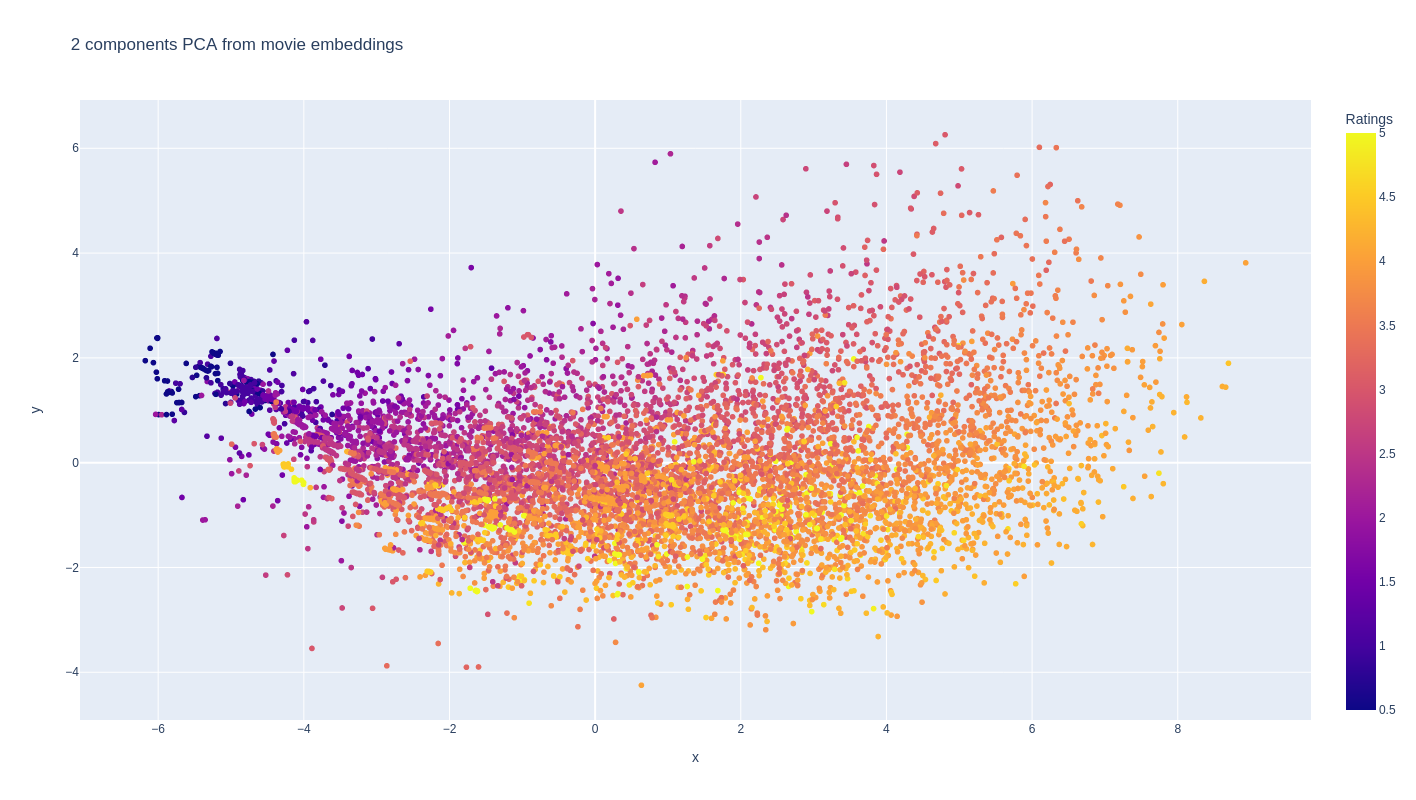

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

#TOFILL


def scatter_plot(components, title, movie_titles, average_ratings):
    
    labels = {str(i): f"PC {i+1}" for i in range(2)}
    labels['color'] = 'Ratings'
    fig = px.scatter(
        x=components.T[0],y=components.T[1],
        color=average_ratings,
        labels=labels,
        width=1000, height=800,
        hover_name=np.array(movie_titles_ordered),
        title=title)
    fig.show()

    
movie_embeddings = best_model.get_weights()[0]
scaled_movie_embeddings = StandardScaler().fit_transform(movie_embeddings)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_movie_embeddings)

movie_titles_ordered = [ml_movie_id_to_title[ inverse_movie_ids_map[i]] for i in range(nb_movies) ]


scatter_plot(principal_components,'2 components PCA from movie embeddings', movie_titles_ordered, data_matrix.mean() )

In [55]:
len(principal_components)
len(scaled_movie_embeddings)
len(movie_embeddings)

9724

## t-sne

Let's do the same with t-sne, an algorithm specialized for visualizing high dimensional spaces, you can read more about it there : https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



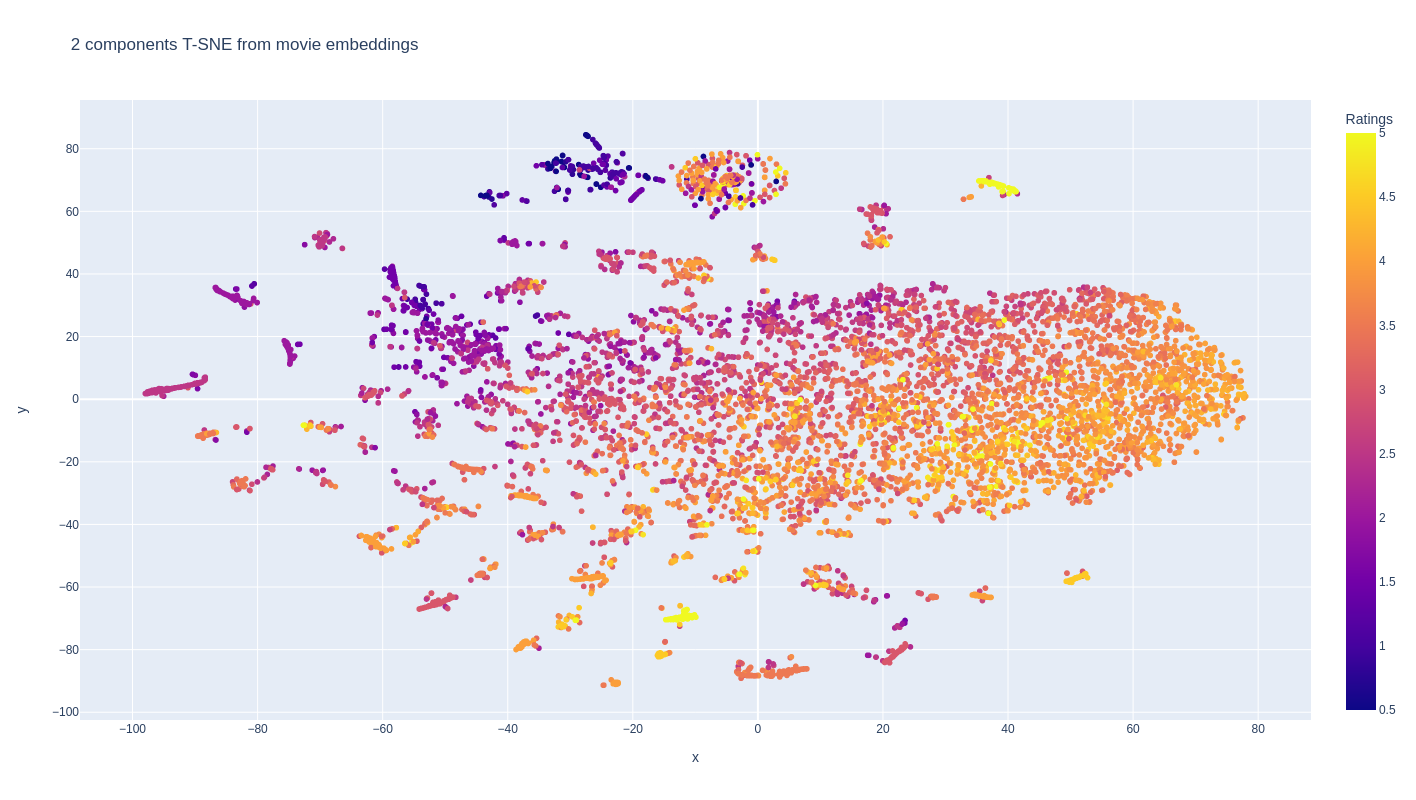

In [36]:
from sklearn.manifold import TSNE

#TOFILL:
tsne_components = TSNE(n_components=2).fit_transform(scaled_movie_embeddings)


scatter_plot(tsne_components,'2 components T-SNE from movie embeddings', movie_titles_ordered, data_matrix.mean() )

T-sne in general tends to preserve local similarities better than PCA. In any case, it's always interesting to try both for visualizing high dimensional data.

Optionally, you can export your embedding and upload them on https://projector.tensorflow.org/ to visualize the embeddings in 3D. You can also use the movies genres from the *movies.csv* file to make one plot for each movie genre and try to see if some parts of the embedding space are representative of a movie genre.

# OPTIONAL PARTS

## Recommend movies to yourself

Implement a function that ask you to rate 20 movies, then add your own ratings to the dataset, retrain the model, and compute your own top-5 predictions.

In [37]:
import random

def rate_my_movies(my_user_id, dataset, nb_movies, nb_to_rate, movie_ids_map):
    """
    Returns a dataframe in the same format as the dataset dataframe, with
    ratings entered by the user for `nb_to_rate` random movies
    
    Input :
        my_user_id : int : The user_id of the new ratings
        dataset : DataFrame : The whole dataset 
        nb_movies : int : Number of unique movie ids
        nb_to_rate : int : Number of movies to rate
        movie_ids_map : dict : The mapping of original file userId to a new index starting at 0.
    
    Output : 
        my_ratings : DataFrame : A dataframe with the same column as `dataset` containing
            the new ratings entered by the user
    """
    #TOFILL
    inverse_movie_ids_map = {v: k for k, v in movie_ids_map.items()}
    movies_info = pd.read_csv('../data/ml-latest-small/movies.csv')
    ml_movie_id_to_title = dict(zip(movies_info['movieId'], movies_info['title']))

    my_ratings = pd.DataFrame(columns = dataset.columns)

    rated = 0
    print("Rate " + str(nb_to_rate) + " movies between 0 and 5, type enter to pass:")

    
    while rated < nb_to_rate:
        movie_id_to_rate = random.randint(0,nb_movies)
        print(ml_movie_id_to_title[ inverse_movie_ids_map[ movie_id_to_rate ] ])

        c = None
        while c not in ['','0','1','2','3','4','5']:
            if c is not None:
                print("Incorrect value, type a rating value between 0 and 5, or 'enter' to pass")
            c = input()

        if c != '':
            my_ratings.loc[rated] = [my_user_id,movie_id_to_rate, int(c), 0]
            rated += 1


#TOKEEP
    return my_ratings

my_user_id = len(user_ids_map)

my_ratings = rate_my_movies(my_user_id, dataset, nb_movies, 20, movie_ids_map)



Rate 20 movies between 0 and 5, type enter to pass:
Chouchou (2003)


 3


Merci Patron ! (2016)


 4


Suddenly (1954)


 3


Horrible Bosses (2011)


 3


Night and Day (1946)


 3


Over the Hedge (2006)


 4


College Road Trip (2008)


 2


The Odyssey (1997)


 5


Lone Survivor (2013)


 3


Sorority Babes in the Slimeball Bowl-O-Rama (1988)


 2


Damned United, The (2009)


 2


Love's Labour's Lost (2000)


 2


Pawnbroker, The (1964)


 3


Turbo: A Power Rangers Movie (1997)


 2


Dark Star (1974)


 4


Tammy (2014)


 3


Normal Life (1996)


 2


New Police Story (Xin jing cha gu shi) (2004)


 2


House of Mirth, The (2000)


 3


Terminal, The (2004)


 3


In [38]:
dataset_with_me = pd.concat([dataset, my_ratings], axis = 0).sample(frac=1).reset_index(drop=True)

X_with_me = [dataset_with_me["userId"].to_numpy(), dataset_with_me["movieId"].to_numpy()]
y_with_me = dataset_with_me["rating"].to_numpy()


In [39]:
best_model=get_mf_bias_l2_reg_model(nb_users + 1, nb_movies,k = best_params['k'], lambda_ = best_params['lambda_'])

early_stopping = EarlyStopping(monitor='val_mse', patience=10, verbose=1, restore_best_weights=True)

best_model.fit(X_with_me, y_with_me, epochs=500, batch_size=512, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/500
178/178 [==============================] - 2s 6ms/step - loss: 12.9946 - mse: 12.9909 - val_loss: 11.8440 - val_mse: 11.8389
Epoch 2/500
178/178 [==============================] - 1s 4ms/step - loss: 11.1097 - mse: 11.0975 - val_loss: 8.0198 - val_mse: 7.9658
Epoch 3/500
178/178 [==============================] - 1s 4ms/step - loss: 6.7346 - mse: 6.6572 - val_loss: 4.0881 - val_mse: 3.9357
Epoch 4/500
178/178 [==============================] - 1s 4ms/step - loss: 3.4560 - mse: 3.2810 - val_loss: 2.7173 - val_mse: 2.4840
Epoch 5/500
178/178 [==============================] - 1s 4ms/step - loss: 2.3736 - mse: 2.1254 - val_loss: 2.2385 - val_mse: 1.9517
Epoch 6/500
178/178 [==============================] - 1s 4ms/step - loss: 1.9224 - mse: 1.6250 - val_loss: 1.9981 - val_mse: 1.6714
Epoch 7/500
178/178 [==============================] - 1s 4ms/step - loss: 1.6863 - mse: 1.3514 - val_loss: 1.8581 - val_mse: 1.5001
Epoch 8/500
178/178 [==============================] - 1s 4ms/s

In [40]:
five_best_movie_ids, five_best_ratings =  get_top5_for_user(best_model, my_user_id, dataset)
for i in range(5):
    print('\t' + ml_movie_id_to_title[ inverse_movie_ids_map[ five_best_movie_ids[i] ] ] + 
          '; predicted rating : ' + str(five_best_ratings[i]) )
print('')

	Three Billboards Outside Ebbing, Missouri (2017); predicted rating : 3.333144
	Shawshank Redemption, The (1994); predicted rating : 3.3052368
	Philadelphia Story, The (1940); predicted rating : 3.233028
	Dark Knight, The (2008); predicted rating : 3.2248154
	Grand Day Out with Wallace and Gromit, A (1989); predicted rating : 3.221087



## Reuse the movie embeddings to predict the movies genre with multi-label classification

Beyond the goal of predicting missing rating, the matrix factorization techniques also produces vectorial representation of movies and users: their embeddings, what we just visualized for the movies. With a big enough dataset, these embeddings actually are good abstract representations of the movies and of the users, and can be reused as features for other tasks, such as classification.

In the *movies.csv*, there is a column that gives the genres of each movie. Let's try to predict the genres of the movies from the embeddings we learnt. As you can see, each movie can have more than one genre, so in classification terms, more than one class. We can achieve that with *multilabel classification*. You can read more about it there: https://scikit-learn.org/stable/modules/multiclass.html

Load the movies genre, encode them as binary classes and use the classes imported below to train a multilabel classifier that uses the movie embeddings as features, and the movie genres as classes. Use the *OneVsRestClassifier* with a simple *LinearSVC* without any hyper-parameter tuning. Finally print the test accuracy, F1, precision and recall for each class, as well as the number of time each class appears in the dataset.

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from collections import defaultdict
#TOFILL

def get_genre_classes(movies_info, movie_ids_map):
    
    genres = set()

    new_class_idx = 0

    genres_to_classes = {}
    
    classes_count = defaultdict(int)

    movie_ids = []
    movie_classes = []

    for i in range(movies_info.shape[0]):
        
        #Some movies in the movies_info are not in the dataset
        if movies_info['movieId'].iloc[i] not in movie_ids_map.keys():
            continue
            
        movie_ids.append( movies_info['movieId'].iloc[i] )
        
        g_string = movies_info['genres'].iloc[i]
        genre_list= g_string.split('|')

        classes_list = []
        for genre in genre_list:
            if genre not in genres:
                genres.add(genre)
                genres_to_classes[genre] = new_class_idx
                new_class_idx += 1

            classes_list.append(genres_to_classes[genre])
            classes_count[genres_to_classes[genre]] +=1
        movie_classes.append(classes_list)

        
    Y_unsorted = MultiLabelBinarizer().fit_transform(movie_classes)
    
    Y = np.empty_like(Y_unsorted)
    
    assert len(movie_ids) == len(movie_ids_map)
    
    for i in range(len(movie_ids)):
        Y[movie_ids_map[movie_ids[i]]] = Y_unsorted[i]
        
    
    return Y, genres_to_classes, classes_count




X = movie_embeddings
Y, genres_to_classes, classes_count = get_genre_classes(movies_info,movie_ids_map)

classes_to_genres = {v: k for k, v in genres_to_classes.items()}

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

clf = OneVsRestClassifier(LinearSVC()).fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [42]:
#TODEL
for i in range(len(classes_to_genres)):
    print(classes_to_genres[i] + " :")
    print("\tCount : " + str(classes_count[i]))
    print("\tAccuracy : " + str(accuracy_score(y_test[:,i], y_pred[:,i])))
    print("\tPrecision : " + str(precision_score(y_test[:,i], y_pred[:,i])))
    print("\tRecall : " + str(recall_score(y_test[:,i], y_pred[:,i])))
    print("\tF1 : " + str(f1_score(y_test[:,i], y_pred[:,i])))
    

    

Adventure :
	Count : 1262
	Accuracy : 0.8715313463514902
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Animation :
	Count : 610
	Accuracy : 0.9383350462487153
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Children :
	Count : 664
	Accuracy : 0.9373072970195272
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Comedy :
	Count : 3753
	Accuracy : 0.645426515930113
	Precision : 0.5974025974025974
	Recall : 0.12777777777777777
	F1 : 0.21052631578947367
Fantasy :
	Count : 778
	Accuracy : 0.9167523124357657
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Romance :
	Count : 1591
	Accuracy : 0.8335046248715313
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Drama :
	Count : 4349
	Accuracy : 0.6073997944501541
	Precision : 0.5702247191011236
	Recall : 0.4699074074074074
	F1 : 0.515228426395939
Action :
	Count : 1828
	Accuracy : 0.8098663926002055
	Precision : 0.5833333333333334
	Recall : 0.0374331550802139
	F1 : 0.07035175879396983
Crime :
	Count : 1196
	Accuracy : 0.8848920863309353
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Thri

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_c

On rare classes, you should get a very high accuracy, with a very low F1. Indeed these classes are really imbalanced : there are a few positives, hence the classifier is largely biased toward the negatives, and rarely predict a positive for these classes. This is why accuracy is generally a bad measure with imbalanced dataset : the high number of true negatives makes the accuracy number high, while our model is actually barely capable of predicting true positives.

Let's compare our classifier performance with a *DummyClassifier*, the dummy classifier takes the ratio $r = \frac{nb\_positives}{nb\_positives + nb\_negatives}$ as the probability to predict a positive, and then do it randomly.

In [43]:
from sklearn.dummy import DummyClassifier

#TOFILL

clf = OneVsRestClassifier(DummyClassifier()).fit(X_train, y_train)
y_pred = clf.predict(X_test)

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning:

`n_features_in_` is deprecated in 1.0 and will be removed in 1.2.



In [44]:
#TODEL
for i in range(len(classes_to_genres)):
    print(classes_to_genres[i] + " :")
    print("\tCount : " + str(classes_count[i]))
    print("\tAccuracy : " + str(accuracy_score(y_test[:,i], y_pred[:,i])))
    print("\tPrecision : " + str(precision_score(y_test[:,i], y_pred[:,i])))
    print("\tRecall : " + str(recall_score(y_test[:,i], y_pred[:,i])))
    print("\tF1 : " + str(f1_score(y_test[:,i], y_pred[:,i])))
    
    

Adventure :
	Count : 1262
	Accuracy : 0.8715313463514902
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Animation :
	Count : 610
	Accuracy : 0.9383350462487153
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Children :
	Count : 664
	Accuracy : 0.9373072970195272
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Comedy :
	Count : 3753
	Accuracy : 0.6300102774922919
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Fantasy :
	Count : 778
	Accuracy : 0.9167523124357657
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Romance :
	Count : 1591
	Accuracy : 0.8335046248715313
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Drama :
	Count : 4349
	Accuracy : 0.5560123329907503
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Action :
	Count : 1828
	Accuracy : 0.8078108941418294
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Crime :
	Count : 1196
	Accuracy : 0.8848920863309353
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Thriller :
	Count : 1889
	Accuracy : 0.8006166495375129
	Precision : 0.0
	Recall : 0.0
	F1 : 0.0
Horror :
	Count : 977
	Accuracy : 0.9013360

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/metrics/_c

As you can see, simply respecting the class balance, even at random, produces better F1 on most classes. One way to compensate for class imbalance is to tell the classifier to weight more the true samples at training time, accordingly with the ratio $r$ between true and false samples. With scikit-learn SVM implementation, you can use the argument *class_weight* for setting the weight of the positive and negative samples at training time. See : https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

But if you just want to set the class weights accordingly with the ratio between positives and negatives, you can just set *class_weight = ‘balanced’*. Test it with the LinearSVC classifier:

In [45]:
#TOFILL

clf = OneVsRestClassifier(LinearSVC(class_weight = 'balanced')).fit(X_train, y_train)
y_pred = clf.predict(X_test)

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [46]:
#TODEL
for i in range(len(classes_to_genres)):
    print(classes_to_genres[i] + " :")
    print("\tCount : " + str(classes_count[i]))
    print("\tAccuracy : " + str(accuracy_score(y_test[:,i], y_pred[:,i])))
    print("\tPrecision : " + str(precision_score(y_test[:,i], y_pred[:,i])))
    print("\tRecall : " + str(recall_score(y_test[:,i], y_pred[:,i])))
    print("\tF1 : " + str(f1_score(y_test[:,i], y_pred[:,i])))


Adventure :
	Count : 1262
	Accuracy : 0.6865364850976362
	Precision : 0.21337579617834396
	Recall : 0.536
	F1 : 0.3052391799544419
Animation :
	Count : 610
	Accuracy : 0.6382322713257965
	Precision : 0.0898876404494382
	Recall : 0.5333333333333333
	F1 : 0.15384615384615383
Children :
	Count : 664
	Accuracy : 0.645426515930113
	Precision : 0.09428571428571429
	Recall : 0.5409836065573771
	F1 : 0.16058394160583941
Comedy :
	Count : 3753
	Accuracy : 0.5590955806783144
	Precision : 0.42483660130718953
	Recall : 0.5416666666666666
	F1 : 0.47619047619047616
Fantasy :
	Count : 778
	Accuracy : 0.6464542651593012
	Precision : 0.11884057971014493
	Recall : 0.5061728395061729
	F1 : 0.19248826291079812
Romance :
	Count : 1591
	Accuracy : 0.5991778006166495
	Precision : 0.21641791044776118
	Recall : 0.5370370370370371
	F1 : 0.30851063829787234
Drama :
	Count : 4349
	Accuracy : 0.6012332990750257
	Precision : 0.5447154471544715
	Recall : 0.6203703703703703
	F1 : 0.5800865800865801
Action :
	Count : 

F1 is now much better than with the dummy classifier, however is is still not very convincing. This is quite normal given the size of the dataset we are using, which is pretty small to get really meaningful embeddings. But with bigger datasets, reusing embeddings as features for auxiliary tasks such as classification is actually a very effective way of doing so when there is no other informations about the items we try to classify. Here the items are the movies, the dataset doesn't provide more information about them, but one could imagine fetching from internet textual descriptions of the movies and use them as features alongside the embeddings to improve the classification results.

## Try out the different SGD algorithms

In all the notebook we used the 'adam' `optimizer` to train our model, which is a variation of SGD. Keras proposes different variations of SGD: https://keras.io/optimizers/ . This article gif images gives an intuitive view of their different behavior : https://medium.com/@ramrajchandradevan/the-evolution-of-gradient-descend-optimization-algorithm-4106a6702d39

Try a few ones with our model and see how the training and testing loss evolves.

In [47]:
#TOFILL

## Add the global bias $\mu$  parameter to the model

Remember we didn't added the global bias $\mu$ to our model yet (Equations (4-5) from Koren's paper). Use your best google skills to find a way to add an embedding layer that does that.

Hint : Use a constant `Input` layer.

In [48]:
from keras import backend as K
#TOFILL

def get_mf_bias_global_model(nb_users, nb_movies, k, lambda_):
    
    dim_embedddings = k
    
    # User embeddings
    u = Input(shape=(1,), dtype='int32', name = 'u__user_id')
    p_u = Embedding(nb_users, dim_embedddings,
                  embeddings_regularizer = regularizers.l2(lambda_), name="p_u__user_embedding")(u)
    p_u = Reshape((dim_embedddings,), name="p_u__user_embedding_reshaped")(p_u)
    
    
    # Movie embeddings
    i = Input(shape=(1,), dtype='int32', name = 'i__movie_id')
    q_i = Embedding(nb_movies, dim_embedddings,
                  embeddings_regularizer = regularizers.l2(lambda_), name="q_i__movie_embedding")(i)
    q_i = Reshape((dim_embedddings,), name="q_i__movie_embedding_reshaped")(q_i)
    
    # Dot product
    d = Dot(axes = 1)([q_i, p_u])  
    
    # User and movie biases
    b_u = Embedding(nb_users, 1,
                  embeddings_regularizer = regularizers.l2(lambda_),  name="b_u__user_bias")(u)
    b_u = Reshape((1,), name="b_u__user_bias_reshaped")(b_u)
    b_i = Embedding(nb_movies, 1,
                  embeddings_regularizer = regularizers.l2(lambda_),  name="b_i__movie_bias")(i)
    b_i = Reshape((1,), name="b_i__movie_bias_reshaped")(b_i)

    # Global bias : hack with constant input
    k_constant = K.variable([0], name = "constant_bias_index", dtype = 'int32')
    fixed_input = Input(tensor=k_constant, dtype='int32', name = 'constant_bias_index_input')
    
    mu = Embedding(1, 1, name="mu__mean_bias")(fixed_input)
    
    # Adding it all
    r_hat = Add()([d, b_u, b_i, mu])
    
    # Defining the model with its inputs and outputs
    model = Model(inputs=[u, i, fixed_input], outputs=r_hat)
    
    # Defining the loss, optimizer and metrics to use
    model.compile(loss='mse', optimizer='adam', metrics=["mse"])
    
  
    return model



In [49]:
#TODEL : all following

In [50]:
mf_bias2_model = get_mf_bias_global_model(nb_users, nb_movies, **best_params)

In [51]:
mf_bias2_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i__movie_id (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
u__user_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
q_i__movie_embedding (Embedding (None, 1, 15)        145860      i__movie_id[0][0]                
__________________________________________________________________________________________________
p_u__user_embedding (Embedding) (None, 1, 15)        9150        u__user_id[0][0]                 
___________________________________________________________________________________________

In [52]:
history = mf_bias2_model.fit(X_train, y_train, epochs=10)

Epoch 1/10


ValueError: in user code:

    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/fernando.arroyo@Digital-Grenoble.local/anaconda3/envs/ML_4_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_13 expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 15) dtype=float32>]


In [ ]:
y_pred = mf_bias2_model.predict(X_test)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))

print(" Test RMSE : %s " % test_rmse)

## Implement your own Stochastic Gradient Descent for Matrix Factorization with numpy instead of Keras (very optional)

Now you know everything to implement your own matrix factorization SGD model, all with numpy arrays. Start without the biases again, and without mini-batches. The gradient update equations are described in page 4 of Koren's paper. Let's initialize your $p$ and $q$ embeddings with a gaussian sampling. Print the RMSE at the beginning of each epoch, and finally compute the RMSE of your model on the test set.

In [ ]:
from numpy.random import normal

P = normal(size = (nb_users,k))
Q = normal(size = (nb_movies,k))

gamma = 0.1
lambda_ = 0.00001
epochs = 10

for e in range(epochs):
    for j in range(train.shape[0]):
        u = train['userId'].iloc[j]
        i = train['movieId'].iloc[j]
        r_ui = train['rating'].iloc[j]
        
        #TOFILL
